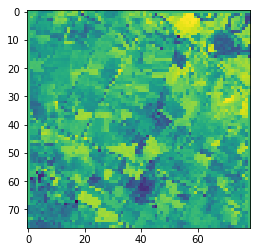

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ee
import random, os, wget, zipfile



def unzipURL(img_url):
    """ Downloads and unzips a file. Returns the path where everything is unzipped. """
    TMP_DIR="./tmp/"+str(random.randrange(999999))
    zip_filename = os.path.join(TMP_DIR, 'zipped_tile.zip')

    # make tmp directory
    if not os.path.exists(TMP_DIR):
        os.makedirs(TMP_DIR)
    # and delete everything in it:
    filelist = [ f for f in os.listdir(TMP_DIR)]
    for f in filelist:
        os.remove(os.path.join(TMP_DIR, f))

    wget.download(img_url, zip_filename)
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(TMP_DIR)
    zip_ref.close()

    return TMP_DIR

    return





ee.Initialize()

maps_collection = ee.ImageCollection('USDA/NAIP/DOQQ')

# create the Google Earth Engine Image object
gee_img = ee.Image(maps_collection.first())

# get the download link from google
path=gee_img.getDownloadUrl({
        'name': 'map_section',  # name the file (otherwise it will be a uninterpretable hash)
        'scale': 100,                              # resolution in meters
        'crs': 'EPSG:4326', #4326                         #  projection
        'bands': [{'id': 'R'}]
        # 'region': bounds.getInfo()['coordinates']
        });

# convert to tiff
tif_location = unzipURL(path)

# get handles to the tiff files

tif_path =os.path.join(tif_location, 'map_section.R.tif')

img=mpimg.imread(tif_path)
plt.imshow(img)
plt.show()



